In [1]:
import pandas as pd
import xarray
import dask
import cftime

In [2]:
dask.config.set(scheduler="processes")

# Locate the data

In [3]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [4]:
members = {
    #'ACCESS-CM2': 'r1i1p1f1', # bad upload into GCS
    'ACCESS-ESM1-5': 'r1i1p1f1',
    'AWI-CM-1-1-MR': 'r1i1p1f1',
    'BCC-CSM2-MR': 'r1i1p1f1',
    'CAMS-CSM1-0': 'r2i1p1f1',
    'CanESM5': 'r1i1p1f1',
    'CESM2': 'r4i1p1f1',
    'CESM2-WACCM': 'r1i1p1f1',
    'CMCC-CM2-SR5': 'r1i1p1f1',
    'CNRM-CM6-1': 'r1i1p1f2',
    'CNRM-CM6-1-HR': 'r1i1p1f2',
    'CNRM-ESM2-1': 'r1i1p1f2',
    'EC-Earth3': 'r1i1p1f1',
    'EC-Earth3-Veg': 'r1i1p1f1',
    'EC-Earth3-Veg-LR': 'r1i1p1f1',
    'FGOALS-g3': 'r1i1p1f1',
    'GFDL-CM4': 'r1i1p1f1',
    'GFDL-ESM4': 'r1i1p1f1',
    'HadGEM3-GC31-LL': 'r1i1p1f3',
    'IITM-ESM': 'r1i1p1f1',
    'INM-CM4-8': 'r1i1p1f1',
    'INM-CM5-0': 'r1i1p1f1',
    'IPSL-CM6A-LR': 'r1i1p1f1',
    'KACE-1-0-G': 'r2i1p1f1',
    'KIOST-ESM': 'r1i1p1f1',
    'MIROC-ES2L': 'r1i1p1f2',
    'MIROC6': 'r1i1p1f1',
    'MPI-ESM1-2-HR': 'r1i1p1f1',
    'MPI-ESM1-2-LR': 'r1i1p1f1',
    'MRI-ESM2-0': 'r1i1p1f1',
    'NESM3': 'r1i1p1f1',
    'NorESM2-LM': 'r1i1p1f1',
    'NorESM2-MM': 'r1i1p1f1',
    'TaiESM1': 'r1i1p1f1',
    'UKESM1-0-LL': 'r1i1p1f2',
}

Lo he hecho para un escenario pero tiene que ser para todos (va a ser como medio TB).

In [22]:
%%time

scenarios = ["ssp126", "ssp245", "ssp370", "ssp585", "historical"]

activity = {sc: "ScenarioMIP" for sc in scenarios}
activity["historical"] = "CMIP"

scenario_models = {sc: [] for sc in scenarios}
scenario_dss    = {sc: [] for sc in scenarios}

for sc in scenarios:
    for i,model in enumerate(members):
        # locate the tas dataset
        subset = pangeo_catalog.query(f"activity_id == '{activity[sc]}' & experiment_id == '{sc}' & source_id == '{model}' & table_id == 'day' & member_id == '{members[model]}' & variable_id == 'tas'").sort_values(by="version", ascending=False)
        if len(subset) == 0:
            print(f"Missing tas for model: {model} and scenario: {sc}")
            continue

        ds = xarray.open_zarr(
            subset["zstore"].iloc[0],
            decode_times=xarray.coders.CFDatetimeCoder(use_cftime=True))

        print(sc, model)

        if sc != "historical":
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "20981230")).convert_calendar("standard", align_on="date") # drops invalid dates
            else:
                ds = ds.sel(time=slice("20150101", "20981231"))
                ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ms", unsafe=True)
        else:
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.convert_calendar("standard", align_on="date") # drops invalid dates
                #ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ms", unsafe=True)

        if len(ds["time"]) == 0:
            print(f"Bad time coordinaate for model: {model} and scenario: {sc}")
            continue

        scenario_models[sc].append("_".join([model, members[model]]))
        scenario_dss[sc].append(ds.resample({"time": "MS"}).mean())

        # if i == 2:
        #     break

Missing tas for model: ACCESS-ESM1-5 and scenario: ssp126
ssp126 AWI-CM-1-1-MR
ssp126 BCC-CSM2-MR
ssp126 CAMS-CSM1-0
ssp126 CanESM5
Bad time coordinaate for model: CanESM5 and scenario: ssp126
ssp126 CESM2
ssp126 CESM2-WACCM
ssp126 CMCC-CM2-SR5
ssp126 CNRM-CM6-1
ssp126 CNRM-CM6-1-HR
ssp126 CNRM-ESM2-1
ssp126 EC-Earth3
ssp126 EC-Earth3-Veg
ssp126 EC-Earth3-Veg-LR
ssp126 FGOALS-g3
Missing tas for model: GFDL-CM4 and scenario: ssp126
ssp126 GFDL-ESM4
ssp126 HadGEM3-GC31-LL
ssp126 IITM-ESM
ssp126 INM-CM4-8
ssp126 INM-CM5-0
ssp126 IPSL-CM6A-LR
ssp126 KACE-1-0-G
ssp126 KIOST-ESM
ssp126 MIROC-ES2L
ssp126 MIROC6
ssp126 MPI-ESM1-2-HR
ssp126 MPI-ESM1-2-LR
ssp126 MRI-ESM2-0
ssp126 NESM3
Missing tas for model: NorESM2-LM and scenario: ssp126
ssp126 NorESM2-MM
Missing tas for model: TaiESM1 and scenario: ssp126
ssp126 UKESM1-0-LL
Missing tas for model: ACCESS-ESM1-5 and scenario: ssp245
ssp245 AWI-CM-1-1-MR
ssp245 BCC-CSM2-MR
ssp245 CAMS-CSM1-0
ssp245 CanESM5
ssp245 CESM2
ssp245 CESM2-WACCM
ssp245 

# Debug

In [23]:
size = 0
for sc in scenarios:
    size += sum([ds["tas"].size * 4 / 2**30 for ds in scenario_dss[sc]])

In [24]:
size

35.245558977127075

# Regrid

In [25]:
iad = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc")

iad = iad.assign_coords(lon=((iad["lon"] + 360) % 360)).sortby("lon")

iad_lat, iad_lon = iad["lat"], iad["lon"]

In [26]:
%%time

scenario_dss_interp = {}

for sc in scenarios:
    scenario_dss_interp[sc] = [
        ds.interp(
            lat=iad["lat"],
            lon=iad["lon"],
            method="linear",
            kwargs={"fill_value": "extrapolate"})
        for ds in scenario_dss[sc]]

CPU times: user 9.06 s, sys: 249 ms, total: 9.31 s
Wall time: 33.7 s


Lo siguiente lanza el regrid del paso anterior (el paso anterior es lazy) y no involucra transferencia de red aparentemente, tal vez solo de las coordenadas o ni eso porq ya deberian estar en el cliente.

In [33]:
%%time

ssp126 = xarray.concat(scenario_dss_interp["ssp126"], xarray.Variable("member", scenario_models["ssp126"]), coords="minimal", compat="override").chunk({"time": -1})
ssp245 = xarray.concat(scenario_dss_interp["ssp245"], xarray.Variable("member", scenario_models["ssp245"]), coords="minimal", compat="override").chunk({"time": -1})
ssp370 = xarray.concat(scenario_dss_interp["ssp370"], xarray.Variable("member", scenario_models["ssp370"]), coords="minimal", compat="override").chunk({"time": -1})
ssp585 = xarray.concat(scenario_dss_interp["ssp585"], xarray.Variable("member", scenario_models["ssp585"]), coords="minimal", compat="override").chunk({"time": -1})

CPU times: user 3.87 s, sys: 80.2 ms, total: 3.95 s
Wall time: 3.96 s


# Cambiar el chunking de time y probar lo de abajo a ver que pasa con la red del hub.

In [34]:
ssp126["tas"]

<xarray.DataArray 'tas' (member: 29, time: 1008, lat: 180, lon: 360)> Size: 8GB
dask.array<rechunk-merge, shape=(29, 1008, 180, 360), dtype=float32, chunksize=(1, 1008, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2098-12-01
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    height    float64 8B ...
    height2m  float64 8B 2.0
  * member    (member) <U25 3kB 'AWI-CM-1-1-MR_r1i1p1f1' ... 'UKESM1-0-LL_r1i...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-07-28T10:32:45Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    original_name:  temp2
    standard_name:  air_temperature
    units:          K

CPU times: user 1min 8s, sys: 3min 4s, total: 4min 12s
Wall time: 6min 6s


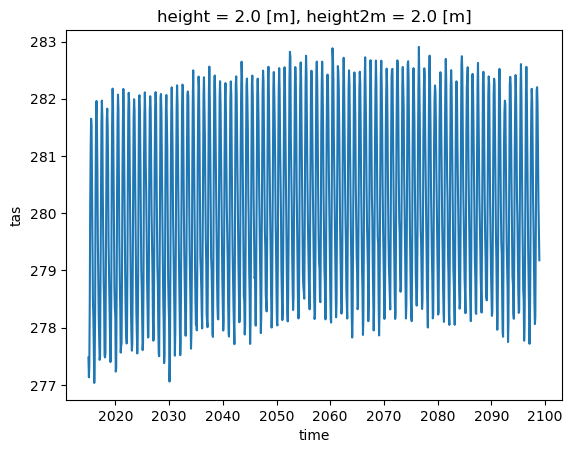

In [19]:
%%time

ssp126["tas"].mean(["member", "lat", "lon"]).plot()

In [20]:
%%time

a = ssp126["tas"].resample({"time": "YE"}).mean().compute() #mean(["member", "lat", "lon"]).plot()

CPU times: user 1min 14s, sys: 3min 13s, total: 4min 28s
Wall time: 5min 55s


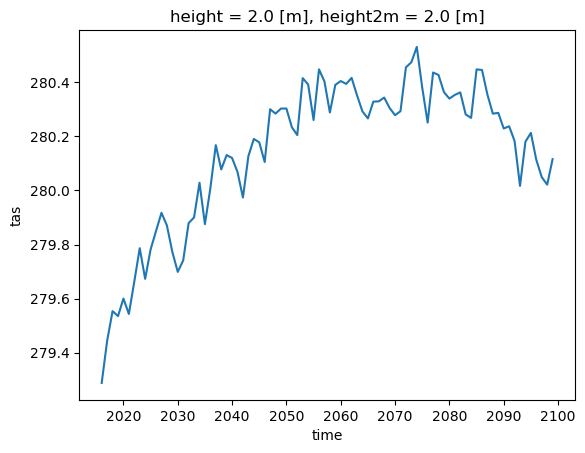

In [22]:
a.mean(["member", "lat", "lon"]).plot()

```
CPU times: user 4min 34s, sys: 8min 41s, total: 13min 16s
Wall time: 28min 44s
```

80GB de red.

In [ ]:
# %%time

# monthly = [ ds.compute(num_workers=8, scheduler="processes").resample({"time": "MS"}).mean() for ds in dss ]

In [ ]:
scenario_dss_mon = {sc: [] for sc in scenarios}
for sc in scenarios:
    for ds in scenario_dss[sc]:
        scenario_dss_mon[sc].append(ds.compute(num_workers=8, scheduler="processes").resample({"time": "MS"}).mean())

In [ ]:
1

In [11]:
# def mon_resample(ds):
#     return ds.compute(num_workers=4, scheduler="processes").resample({"time": "MS"}).mean()

In [12]:
# %%time

# scenario_dss_mon = {sc: None for sc in scenarios}
# for sc in scenarios:
#     with multiprocessing.Pool(4) as pool:
#         scenario_dss_mon[sc] = pool.map(mon_resample, scenario_dss[sc])

AssertionError: daemonic processes are not allowed to have children

## Interpolate

In [7]:
iad_catalog = pd.read_csv("https://raw.githubusercontent.com/SantanderMetGroup/IPCC-Atlas-Datalab/refs/heads/main/data_inventory.csv")
iad_subset = iad_catalog.query('type == "opendap" & variable == "t" & project == "CMIP6" & experiment == "ssp585" & frequency == "mon"')
iad_location = iad_subset["location"].iloc[0]
iad_location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc'

In [8]:
iad = xarray.open_dataset(iad_location)
iad["t"]

<xarray.DataArray 't' (member: 34, time: 1032, lat: 180, lon: 360)> Size: 9GB
[2273702400 values with dtype=float32]
Coordinates:
  * member    (member) |S64 2kB b'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1' ... b'MOH...
  * time      (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2100-12-01
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    height2m  float64 8B ...
Attributes:
    standard_name:  air_temperature
    units:          degC
    cell_methods:   time: mean within days time: mean over days area: mean
    long_name:      Monthly mean of daily mean temperature
    comment:        Monthly mean of daily mean near-surface (usually, 2 meter...
    grid_mapping:   crs
    _ChunkSizes:    [  1   1 180 360]

In [26]:
# %%time

# interp = [ds.interp(lat=iad["lat"], lon=iad["lon"], method='linear') for ds in dss]

CPU times: user 647 ms, sys: 16.9 ms, total: 663 ms
Wall time: 2.61 s


In [12]:
%%time

time_means = [ds.mean(["lat", "lon"]).compute() for ds in monthly]

CPU times: user 4.09 s, sys: 2.72 s, total: 6.81 s
Wall time: 6.81 s


In [14]:
for x in time_means:
    print(x.shape)

(1200,)
(3432,)
(1032,)
(1020,)
(1992,)
(3421,)
(1032,)
(1032,)
(1032,)
(1032,)
(1032,)
(1032,)
(1032,)
(1020,)
(1032,)
(1032,)
(1032,)
(1032,)
(1032,)


Los de 1032 son los buenos.

In [45]:
for ds in time_means[-4:]:
    if isinstance(ds.indexes["time"], xarray.CFTimeIndex):
        ds["time"] = ds.indexes["time"].to_datetimeindex()

/tmp/ipykernel_430710/629221361.py:3: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  ds["time"] = ds.indexes["time"].to_datetimeindex()
/tmp/ipykernel_430710/629221361.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"] = ds.indexes["time"].to_datetimeindex()


In [49]:
a = xarray.concat(time_means[-4:], xarray.Variable("model", list(versions.keys())[-4:]))
a

<xarray.DataArray 'tas' (model: 4, time: 1032)> Size: 17kB
array([[279.99658, 279.1533 , 278.93906, ..., 285.66278, 285.73883,
        285.35312],
       [277.46463, 276.85974, 277.214  , ..., 283.05704, 282.7467 ,
        282.33585],
       [277.8929 , 277.21667, 277.2111 , ..., 282.71616, 282.78235,
        282.71735],
       [276.54477, 276.2519 , 276.788  , ..., 284.6686 , 284.30914,
        284.39087]], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2100-12-01
  * model    (model) <U13 208B 'MIROC-ES2L' 'MPI-ESM1-2-HR' ... 'TaiESM1'